<a href="https://colab.research.google.com/github/TSHP/DL4SC_Neural_ODEs/blob/main/VOC_Dataset_with_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import torch.nn as nn
import numpy
from torch.nn import ReLU
from torch import optim
import matplotlib.pyplot as plt
from torch.nn.functional import one_hot

In [2]:
from torchvision.datasets import VOCSegmentation

# Set the root directory where you want to download the dataset
root = "/path/to/save/voc_dataset"

# Define the year and split (train or val) you want to download
year = "2012"
split = "train"

# Download the VOC dataset
voc_dataset = VOCSegmentation(root=root, year=year, image_set=split, download=True)

100%|██████████| 1999639040/1999639040 [01:08<00:00, 29109373.51it/s]


Extracting /path/to/save/voc_dataset/VOCtrainval_11-May-2012.tar to /path/to/save/voc_dataset


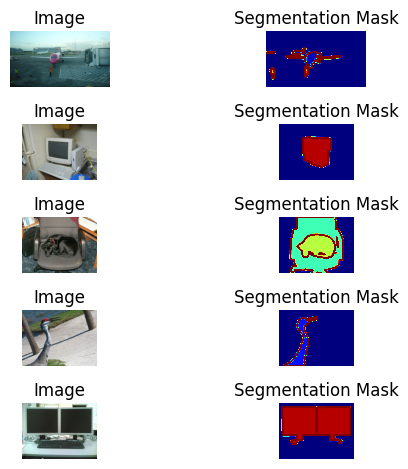

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

# Iterate over the first 5 samples in the dataset
for i in range(5):
    # Get the image and mask from the dataset
    image, mask = voc_dataset[i]

    # Convert the image tensor to a PIL image and then to a NumPy array
    image_np = np.array(image)

    # Convert the mask tensor to a NumPy array
    mask_np = np.array(mask)

    # Display the image and mask
    plt.subplot(5, 2, i * 2 + 1)
    plt.imshow(image_np)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(5, 2, i * 2 + 2)
    plt.imshow(mask_np, cmap='jet', vmin=0, vmax=21)  # Assuming 21 classes in the segmentation mask
    plt.title("Segmentation Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class CustomVOCDataset(Dataset):
    def __init__(self, voc_dataset, transform_image=None, transform_mask=None):
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.voc_dataset = voc_dataset

    def __len__(self):
        return len(self.voc_dataset)

    def __getitem__(self, idx):
        image, mask = self.voc_dataset[idx]

        if self.transform_image is not None:
            image = self.transform_image(image)
        if self.transform_mask is not None:
            mask = self.transform_mask(mask)
        return image, mask

# Set the root directory where the VOC dataset is located
data_dir = "/path/to/voc_dataset"

# Set the year and split you want to use (e.g., "2012" and "train")
year = "2012"
split = "train"

out_size = 32
# Define your transformations
transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize((out_size, out_size)),
    transforms.ToTensor(),
])

# Create an instance of your custom dataset with the specified transformations
dataset = CustomVOCDataset(voc_dataset, transform_image=transform_image,
                           transform_mask=transform_mask)

# Create a data loader with the desired batch size and number of workers
VOC_data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

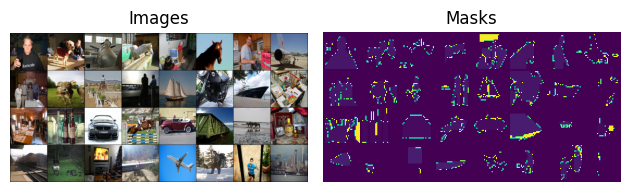

In [6]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Get the first batch from the data loader
batch = next(iter(VOC_data_loader))

# Extract images and masks from the batch
images, masks = batch

# Create a grid of images for visualization
grid_images = make_grid(images)
grid_masks = make_grid(masks)

# Convert tensors to numpy arrays
grid_images_np = grid_images.numpy().transpose(1, 2, 0)
grid_masks_np = grid_masks.numpy().transpose(1, 2, 0)

# Display the grid of images and masks
plt.subplot(1, 2, 1)
plt.imshow(grid_images_np)
plt.title("Images")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(grid_masks_np[:, :, 0])
plt.title("Masks")
plt.axis("off")

plt.tight_layout()
plt.show()

In [7]:
print(images.shape)
print(masks.shape)

torch.Size([32, 3, 256, 256])
torch.Size([32, 1, 32, 32])


In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out += identity
        out = self.relu(out)

        return out

# Define the ResNet model
class ResNet6_images(nn.Module):
    def __init__(self, in_channels):
        super(ResNet6_images, self).__init__()
        w = 32
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=w, kernel_size=3, stride=1),
            nn.BatchNorm2d(w),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=w, out_channels=w, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(w),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=w, out_channels=w, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(w),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=w, out_channels=w, kernel_size=3, stride=2, padding=1),
        )
        self.residual_blocks = nn.Sequential(
            ResidualBlock(w, w),
            ResidualBlock(w, w),
            ResidualBlock(w, w),
            ResidualBlock(w, w),
            ResidualBlock(w, w),
            ResidualBlock(w, w)
        )
        self.final = nn.Sequential(nn.Conv2d(in_channels=w, out_channels=1, kernel_size=1, stride=1),
                      nn.BatchNorm2d(1),
                      nn.ReLU(inplace=True))

    def forward(self, x):
        out = self.downsample(x)
        out = self.residual_blocks(out)
        out = self.final(out)
        return out

In [9]:
def dice_loss(predicted, target):
    smooth = 1e-7  # A small constant to avoid division by zero
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    loss = 1.0 - dice
    return loss

In [ ]:
# Create an instance of the ResNet model
model_ResNet = ResNet6_images(in_channels=3)

# Define the training parameters
learning_rate = 0.0001
num_epochs = 20
print_interval = 5

optimizer = optim.Adam(model_ResNet.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    eval_counter = 0

    for i, (images, labels) in enumerate(VOC_data_loader, 1):
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model_ResNet(images)
        loss = dice_loss(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        eval_counter += 1

        # Print the running loss every 'print_interval' evaluations
        if eval_counter % print_interval == 0:
            average_loss = running_loss / print_interval
            print(f"Epoch [{epoch+1}/{num_epochs}], Evaluation [{i}/{len(VOC_data_loader)}], Loss: {average_loss}")
            running_loss = 0.0
            eval_counter = 0

    # Print the remaining running loss at the end of the epoch
    if eval_counter > 0:
        average_loss = running_loss / eval_counter
        print(f"Epoch [{epoch+1}/{num_epochs}], Evaluation [{i}/{len(VOC_data_loader)}], Loss: {average_loss}")